# Titanic: Machine Learning from Disaster

## 1.0 Introduction

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean on April 15, 1912, during her maiden voyage, after colliding with an iceberg. It is one of the most infamous shipwrecks in human history, killing 1502 out of 2224 passengers and crew and is considered to be the deadliest commercial peacetime maritime disasters in modern history. 

In this notebook, I will build a machine learning model which will predict whether a passenger on the Titanic would have survived. 

To begin, we need to import the necessary libraries:

In [1]:
# Centering the plots in the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    displ ay: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

In [2]:
#We then import the helpful libraries and the data.
%matplotlib inline

import numpy as np 
import pandas as pd
import os
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
# Read in both the train and test data
train = pd.read_csv("_data/train.csv")
test = pd.read_csv("_data/test.csv")

## 2.0 Exploratory Data Analysis (EDA)

<AxesSubplot:>

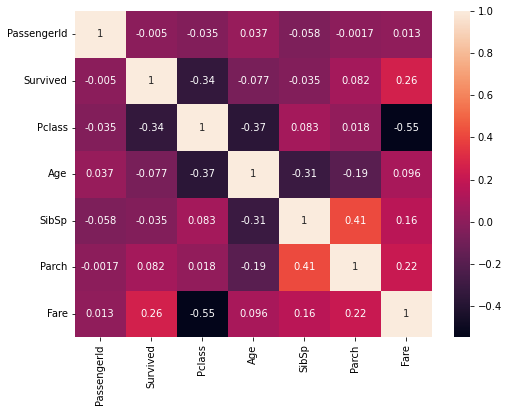

In [4]:
# Create a correlation heat map to see how the columns in the training dataset interact with each other
fig, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(train.corr(), annot = True)

### 2.1 Cleaning data

In [5]:
print('Train shape:', train.shape)

Train shape: (891, 12)


In [6]:
print('Test shape:', test.shape)

Test shape: (418, 11)


In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The above analysis shows that we have 891 observations, 11 features and the target variable 'Survived'.

From Kaggle we know the feature names are:
- Survival = whether the passenger had survived with 0 being no and 1 being yes
- Pclass = Ticket class
- Sex
- Age
- Sibsp = # of siblings / spouses aboard the Titanic
- Parch = # of parents / children aboard the Titanic
- Ticket = Ticket number
- Fare
- Cabin = Cabin number
- Embarked = Port of Embarkation

We can note a few things regarding the data quality which we will need to address in this analysis:
- Some features contain missing values.
- There are some features which will need to be converted to numberical values so the models will be able to process them. 
- Some features will need to be converted to roughly the same scale as each other, due to having a wide range of values.

#### 2.2.1 Missing values
The following function will assess how many missing values are in both of our datasets

In [10]:
def missing_values_table(data):
    missing_values = data.isnull().sum().sort_values(ascending = False)
    missing_percent = data.isnull().sum()/data.isnull().count()*100
    missing_percent = (round(missing_percent, 1)).sort_values(ascending = False)

    table = pd.concat([missing_values, missing_percent], axis=1, keys=['Total', 'Percent'])
    table = table[table['Percent'] > 0]
    return table

In [11]:
missing_values_table(train)

,Total,Percent
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [12]:
missing_values_table(test)

,Total,Percent
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


##### 2.2.1.1 Cabin missing values

The above table shows that a significant number of values are missing from the cabin column (more than 77% in both test and train tables). The format of this feature is deck letter and cabin number - e.g. C85

In order to make this feature more useful, I will extract the deck letter from the cabin number where available, and create a new feature 'deck'. I will then drop the cabin feature.

In [13]:
data = [train, test]
for dataset in data:
    dataset['deck'] = dataset['Cabin'].str[0].fillna("U")
    dataset['deck'] = LabelEncoder().fit_transform(dataset['deck'])

In [14]:
test = test.drop(['Cabin'], axis = 1)
train = train.drop(['Cabin'], axis = 1)

Check that works

In [15]:
train['deck'].describe()

count    891.000000
mean       6.716049
std        2.460739
min        0.000000
25%        8.000000
50%        8.000000
75%        8.000000
max        8.000000
Name: deck, dtype: float64

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
 11  deck         891 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 80.2+ KB


#####  2.2.1.2 Age missing values

The above table shows that 177 values are missing from the age column in the train table, while 86 are missing in the test table. 

We might be able to use the correlation between age and both cabin class and Sibsp to fill in these missing values. 

In [17]:
train.groupby(['Pclass','Survived'])['Age'].median()

Pclass  Survived
1       0           45.25
        1           35.00
2       0           30.50
        1           28.00
3       0           25.00
        1           22.00
Name: Age, dtype: float64

In [18]:
#Filling the missing values with mean of Pclass and Sex.
data = [train, test]
for dataset in data:
    dataset["Age"].fillna(dataset.groupby(['Pclass'])['Age'].transform("mean"), inplace=True)
    dataset["Age"] = dataset["Age"].astype(int)

Check that works

In [19]:
train['Age'].describe()

count    891.000000
mean      29.236813
std       13.220219
min        0.000000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

##### 2.2.1.3 Embarked missing values

A small number of embarked values are missing in the train dataframe. I will replace them with the mode, which I believe is Southampton (where I went to university!).

In [20]:
train['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [21]:
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    #Apply a label to each of the items in the column
    dataset['Embarked'] = LabelEncoder().fit_transform(dataset['Embarked'])

Let's check that worked

In [22]:
train['Embarked'].describe()

count    891.000000
mean       1.536476
std        0.791503
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: Embarked, dtype: float64

##### 2.2.1.4 Fare missing values

There is 1 missing value for fare in the test table. I will replace this with the mean of the fare amounts using cabin class.

In [23]:
#Filling the missing values with mean of Pclass and amending it to an integer
data = [train, test]
for dataset in data:
    dataset['Fare'].fillna(train.groupby(['Pclass'])['Fare'].transform('mean'), inplace=True)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [24]:
train['Fare'].describe()

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

#### 2.2.2 Converting features

I will now transfer columns that are still strings or floats to integers. I will also be extracting important information from columns to make them more useful for my model. 

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Survived     891 non-null    int64 
 2   Pclass       891 non-null    int64 
 3   Name         891 non-null    object
 4   Sex          891 non-null    object
 5   Age          891 non-null    int32 
 6   SibSp        891 non-null    int64 
 7   Parch        891 non-null    int64 
 8   Ticket       891 non-null    object
 9   Fare         891 non-null    int32 
 10  Embarked     891 non-null    int32 
 11  deck         891 non-null    int32 
dtypes: int32(4), int64(5), object(3)
memory usage: 69.7+ KB


##### 2.2.2.1 Name

I will extract the title from the name, and will replace them with more commonly known titles, such as Miss, Mrs and Mr. Any that don't fall into these groupings will be called 'Rare'. Once done, I will replace the titles with a value, in order to make it a feature more usable when modelling. 

In [26]:
data = [train, test]

In [27]:
for dataset in data:
    # extract the titles from the name column
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Countess','Capt','Col','Dr','Major','Rev','Jonkheer'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Mme','Lady','Dona'], 'Mrs')
    dataset['Title'] = dataset['Title'].replace(['Sir','Don'], 'Mr')
    dataset['Title'] = LabelEncoder().fit_transform(dataset['Title'])

In [28]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [29]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck,Title
0,1,0,3,male,22,1,0,A/5 21171,7,2,8,2
1,2,1,1,female,38,1,0,PC 17599,71,0,2,3
2,3,1,3,female,26,0,0,STON/O2. 3101282,7,2,8,1
3,4,1,1,female,35,1,0,113803,53,2,2,3
4,5,0,3,male,35,0,0,373450,8,2,8,2


##### 2.2.2.2 Sex

I will replace the gender values to either 0's or 1's in order to make this feature more usable

In [30]:
change = {'female' : 0, 'male' : 1}

In [31]:
data = [train, test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(change)

In [32]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck,Title
0,1,0,3,1,22,1,0,A/5 21171,7,2,8,2
1,2,1,1,0,38,1,0,PC 17599,71,0,2,3
2,3,1,3,0,26,0,0,STON/O2. 3101282,7,2,8,1
3,4,1,1,0,35,1,0,113803,53,2,2,3
4,5,0,3,1,35,0,0,373450,8,2,8,2


##### 2.2.2.4 Family

I will create a new column which will show the total number of each family. I will add an extra 1 for the same passenger. 

In [33]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [34]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck,Title,FamilySize
0,1,0,3,1,22,1,0,A/5 21171,7,2,8,2,2
1,2,1,1,0,38,1,0,PC 17599,71,0,2,3,2
2,3,1,3,0,26,0,0,STON/O2. 3101282,7,2,8,1,1
3,4,1,1,0,35,1,0,113803,53,2,2,3,2
4,5,0,3,1,35,0,0,373450,8,2,8,2,1


##### 2.2.2.3 Ticket

I will extract the ticket number, and remove the letter part of the ticket. This gives us an idea of where the individual was. I will also replace LINE to be 0.

In [35]:
data = [train, test]
for dataset in data:
    dataset['Ticket'] = dataset['Ticket'].str.split().apply(lambda x : 0 if x[:][-1] == 'LINE' else x[:][-1])
    dataset['Ticket'] = dataset['Ticket'].values.astype('int64')

In [36]:
train['Ticket'].value_counts()

2343       7
347082     7
1601       7
3101295    6
2144       6
          ..
9234       1
19988      1
2693       1
17612      1
370376     1
Name: Ticket, Length: 679, dtype: int64

Final checks before we start modelling

In [37]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck,Title,FamilySize
0,1,0,3,1,22,1,0,21171,7,2,8,2,2
1,2,1,1,0,38,1,0,17599,71,0,2,3,2
2,3,1,3,0,26,0,0,3101282,7,2,8,1,1
3,4,1,1,0,35,1,0,113803,53,2,2,3,2
4,5,0,3,1,35,0,0,373450,8,2,8,2,1


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Pclass       891 non-null    int64
 3   Sex          891 non-null    int64
 4   Age          891 non-null    int32
 5   SibSp        891 non-null    int64
 6   Parch        891 non-null    int64
 7   Ticket       891 non-null    int64
 8   Fare         891 non-null    int32
 9   Embarked     891 non-null    int32
 10  deck         891 non-null    int32
 11  Title        891 non-null    int32
 12  FamilySize   891 non-null    int64
dtypes: int32(5), int64(8)
memory usage: 73.2 KB


In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Sex          418 non-null    int64
 3   Age          418 non-null    int32
 4   SibSp        418 non-null    int64
 5   Parch        418 non-null    int64
 6   Ticket       418 non-null    int64
 7   Fare         418 non-null    int32
 8   Embarked     418 non-null    int32
 9   deck         418 non-null    int32
 10  Title        418 non-null    int32
 11  FamilySize   418 non-null    int64
dtypes: int32(5), int64(7)
memory usage: 31.1 KB


Todo:
- Age and fare need to be in bins
- Hyperparameter tuning?
- One hot encoding?
- Modelling